### Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [28]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [29]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=73)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [30]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("performance_measures is:", type(ols_performance_train.performance_measures))

{'Pos': 10000, 'Neg': 10000, 'TP': 5423, 'TN': 4542, 'FP': 5458, 'FN': 4577, 'Accuracy': 0.49825, 'Precision': 0.49839169194007904, 'Recall': 0.5423, 'desc': 'ols_train'}
performance_measures is: <class 'dict'>


### MODEL: SVM, linear

In [31]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [32]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [33]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 9602, 'TN': 9847, 'FP': 153, 'FN': 398, 'Accuracy': 0.97245, 'Precision': 0.984315735520246, 'Recall': 0.9602, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [34]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [35]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 8286, 'TN': 7246, 'FP': 2754, 'FN': 1714, 'Accuracy': 0.7766, 'Precision': 0.7505434782608695, 'Recall': 0.8286, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

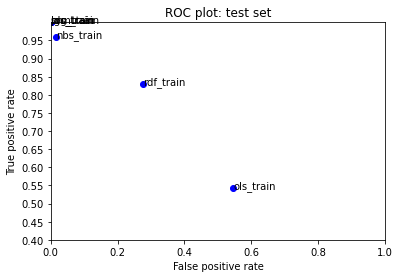

In [37]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [38]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

TP_rate =[]
FP_rate =[]
rows = ['ordinary least sq','support vector','logistic reg','naive bayes','perceptron','ridge reg','random forest']
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
train_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
train_table = train_table.reindex(column_order, axis=1)

print(train_table)

                   True Positive Rate  False Positive Rate
Rows                                                      
logistic reg                   1.0000               0.0000
perceptron                     1.0000               0.0000
ridge reg                      1.0000               0.0000
support vector                 1.0000               0.0000
naive bayes                    0.9602               0.0153
random forest                  0.8286               0.2754
ordinary least sq              0.5423               0.5458


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [39]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [40]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
21
while being one of the \stars\" of this film doesn't necessarily give me sage insight, i do know quite a bit of what was first there...and what ended up on the screen. i remember seeing the original cut of \"incoming freshman\" and being very pleased. it was funny, sexy, raunchy, all the main requirements of a drive-in film. you have to remember this was shot and released before all the rest...animal house, porky's, etc...so in its own way, this flick was truly ahead of its time. for whatever reasons, the film was given to the main distributors who editing out half the original film, and then edited in (should i say \"shuffled?\") THE most random scenes ever. the fat guy, the people with goat heads....what the heck was all that?! i'm sure it was put in for additional T&A, but it was so slowly paced, it caused anything going on prior to it to grind to a screeching and painful halt. but all in all, it's a fun memory for me...especially in that i'm able to 

3554
...however I am not one of them. Caro Diario at least was watchable for two thirds of the time, but the boring and self-centred third section of that movie gave us a taste of what was to come in this extraordinarily self-indulgent mess. Moretti says he feels a need to make this movie, but doesn't want to, whereas the viewer feels that he should stick with it, but really doesn't want to either. A film about Italian politics and elections could be fascinating, but this is not that film. At one point, Moretti and his friends are standing outside the Communist Party headquarters, discussing the interviews they are preparing to conduct with Party leaders inside, but it's characteristic of this film that we never get to see anything of them. Interposed with Moretti's political ravings are the events leading up to the birth of his son, and subsequent home movie shots of him with the baby and later the infant Pietro (the film drags us through several years and more than one election perio

7732
The title above is used to introduce the film \Gen\" to its audience. Gen is about a young doctor(Doga Rutkay) with an ill mother. The film starts with her leaving her mother behind to start her new job. While she drives, we realise that she is not that close home as the hospital is in a remote area. As soon as she steps into the garden of the hospital, she sees the death body of a patient. This is the beginning of a nightmare for the next few days.<br /><br />Two policemen comes to the hospital so as to investigate the suicide. In fact, they will have to stay in the hospital because all roads are cut off due to bad weather conditions. All their communication with outside world is cut off too. There is no way out!! In those few days, there will be more nasty murders. Now everybody suspects from each other.<br /><br />In my opinion, the idea is brilliant. It could have been very scary indeed. There are positive sides of the movie of course. I really like the beginning of the movie.

10829
Pathetic... worse than a bad made-for-TV movie. I can't believe that Spacey and Freeman were in this flick. For some reason Morgan Freeman's character is constantly talking about and saying \pussy\" when referring to NSync boy's girlfriend. Morgan Freeman calling women \"pussy\" is just awkward... What the hell were the people behind this film thinking? Too many plot holes to imagine combined with the horrid acting, confusing camera angles, a lame script and cheap background music made this movie absolutely unbearable.<br /><br />I rented this flop with low expectations.... but... well... it really sucked."
* * * * * * * * * 
10956
Revenge is one of my favorite themes in film. Moreso, \the futility of revenge\" is one of my favorite themes in film. Having seen Gaspar Noe's Irreversible (2002), I was expecting an even more relevant expression of this theme. Instead, this film is a weak half-hearted attempt which expressed nothing but the film's lack of conviction and focus.<br /><

14239
Final Score: 0 (out of 10)<br /><br />***Possible scene specific spoilers (but who the hell cares)***<br /><br />Yes, that's right: zero. And I rarely give 1's. Even for the lamest of movies I look for things like music, cinematography, imagination, it's humor, even a good pace to be as objective about the score as possible. Looking at it within it's own genera or subgenera. But there is absolutely nothing redeeming here. I can't remember another time a movie actually sent me pacing up and down the room when it was over. The only reason I made it to the end was because I couldn't seem to change the channel - I sat there simply aghast, watching to see what insultingly stupid bit it would come up with next. It was like watching a snake digest a rat. <br /><br />But let's have some fun and pull this baby apart, shall we. First of all, There is nothing technical about \Whipped\" that works. The visuals are all sitcom style. The cut scenes all just pictures of the street traffic going

17699
This was by far the worst low budget horror movie i have ever seen. I am an open minded guy and i always love a good horror movie. In fact, when I'm renting movies i specifically look for some good underrated horror movies. They are always good for a laugh, believe i know, i have seen many. But this movie was just so terrible it wasn't worth a chuckle. I was considering turning it off in the first five minutes... which i probably should have. There is nothing good about it, first and foremost, the camera crew suck3d A$$. The intro was stupid just like the ending. Acting and special effects were terrible. Please I'm begging you, do NOT watch this movie, you will absolutely hate it.
* * * * * * * * * 
17768
In a movie that follows a struggling actor, played, evidently, by a struggling actor, this does no favours for Chris Klein. He struggles to bring anything memorable to the role and meanders on through the shallow script managing to display, what could only be described as, a bla

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [41]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1442, 'TN': 1063, 'FP': 1437, 'FN': 1058, 'Accuracy': 0.501, 'Precision': 0.5008683570684266, 'Recall': 0.5768, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [42]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2106, 'TN': 2108, 'FP': 392, 'FN': 394, 'Accuracy': 0.8428, 'Precision': 0.8430744595676541, 'Recall': 0.8424, 'desc': 'svm_test'}


### MODEL: logistic regression

In [43]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2093, 'TN': 2118, 'FP': 382, 'FN': 407, 'Accuracy': 0.8422, 'Precision': 0.8456565656565657, 'Recall': 0.8372, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [44]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1852, 'TN': 1877, 'FP': 623, 'FN': 648, 'Accuracy': 0.7458, 'Precision': 0.7482828282828283, 'Recall': 0.7408, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [45]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2075, 'TN': 2102, 'FP': 398, 'FN': 425, 'Accuracy': 0.8354, 'Precision': 0.8390618681763041, 'Recall': 0.83, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [46]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2066, 'TN': 2010, 'FP': 490, 'FN': 434, 'Accuracy': 0.8152, 'Precision': 0.8082942097026604, 'Recall': 0.8264, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [47]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)
print(rdf_performance_test)

{'Pos': 2500, 'Neg': 2500, 'TP': 2031, 'TN': 1819, 'FP': 681, 'FN': 469, 'Accuracy': 0.77, 'Precision': 0.7488938053097345, 'Recall': 0.8124, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

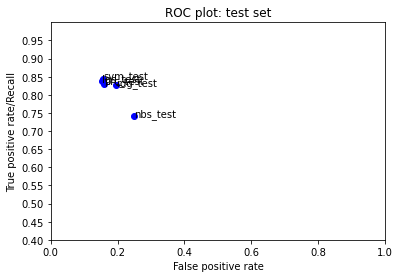

In [48]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate/Recall')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [50]:
#https://pavopax.github.io/2017/11/precision-recall/
#https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba#:~:text=Recall%20and%20True%20Positive%20Rate,denominator%20contains%20the%20true%20negatives.
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
TP_rate =[]
FP_rate =[]
rows = ['ordinary least sq','support vector','logistic reg','naive bayes','perceptron','ridge reg','random forest']
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
test_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
test_table = test_table.reindex(column_order, axis=1)

print(test_table)

                   True Positive Rate  False Positive Rate
Rows                                                      
support vector                 0.8424               0.1568
logistic reg                   0.8372               0.1528
perceptron                     0.8300               0.1592
ridge reg                      0.8264               0.1960
random forest                  0.8124               0.2724
naive bayes                    0.7408               0.2492
ordinary least sq              0.5768               0.5748


---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation